# Etapa 2 - Integração e Limpeza de Dados

In [ ]:
# Bibliotecas

import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind

# Carregamento do Dataset
path = './Mortalidade_Geral_2020.csv'
df = pd.read_csv(path, sep=';')

/tmp/ipython-input-1311160918.py:12: DtypeWarning: Columns (66,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=';')


## Limpeza do Dataset

In [52]:
# Filtrando Dataset

# Colunas necessárias para o trabalho
df_filtrado = df[['IDADE', 'DTOBITO', 'CODMUNOCOR', 'SEXO', 'RACACOR', 'LOCOCOR', 'ESCFALAGR1', 'ESC', 'ESC2010', 'ASSISTMED', 'CIRCOBITO', 'NECROPSIA', 'CAUSABAS', 'TPPOS', 'LINHAII']]

# Colunas a serem filtradas

# Normalizar coluna idade
def converte_idade_valor(valor):
    if pd.isna(valor):
        return np.nan  # nulo se não for número

    # Garantir que é positivo (ex: 415.0 -> 415)
    valor = int(valor)

    unidade = valor // 100       # primeiro dígito
    quantidade = valor % 100     # últimos dois dígitos

    if unidade == 1:  # minutos
        return 0
    elif unidade == 2:  # horas
        return 0
    elif unidade == 3:  # meses
        return 0
    elif unidade == 4:  # anos
        return quantidade
    elif unidade == 5:  # +100 anos
        return 100 + quantidade
    else:
        return np.nan  # valor inválido

df_filtrado['IDADE'] = df_filtrado['IDADE'].apply(converte_idade_valor)

# Filtro para apenas top-10 capitais
# São Paulo (SP)             | 3550308     |
# Rio de Janeiro (RJ)        | 3304557     |
# Brasília (DF)              | 5300108     |
# Fortaleza (CE)             | 2304400     |
# Salvador (BA)              | 2927408     |
# Belo Horizonte (MG)        | 3106200     |
# Manaus (AM)                | 1302603     |
# Curitiba (PR)              | 4106902     |
# Recife (PE)                | 2611606     |
# Goiânia (GO)               | 5208707     |
codigos_capitais = [355030, 330455, 530010, 230440, 292740, 310620, 130260, 410690, 261160, 520870]
df_filtrado = df_filtrado[df_filtrado['CODMUNOCOR'].isin(codigos_capitais)]

# Filtro de doenças respiratórias
df_filtrado['CAUSABAS'] = df_filtrado['CAUSABAS'].apply(
    lambda x: 1 if isinstance(x, str) and (
        x.startswith('A15') or
        x.startswith('A16') or
        x.startswith('A17') or
        x.startswith('A18') or
        x.startswith('A19') or
        x.startswith('J') or
        x.startswith('B342')
    ) else 0
)
df_filtrado.rename(columns={'CAUSABAS': 'DOENCA_RESPIRATORIA'}, inplace=True)

df_filtrado['LINHAII'] = df_filtrado['LINHAII'].apply(
    lambda x: 1 if isinstance(x, str) and (
        x.startswith('*A15') or
        x.startswith('*A16') or
        x.startswith('*A17') or
        x.startswith('*A18') or
        x.startswith('*A19') or
        x.startswith('*J') or
        x.startswith('*B342')
    ) else 0
)
df_filtrado.rename(columns={'LINHAII': 'DOENCA_RESPIRATORIA_CONTRIBUINTE'}, inplace=True)

# Peso para necropsia, óbitos com necropsia = 0.75, óbitos sem necropsia = 0.25
df_filtrado = df_filtrado[df_filtrado['NECROPSIA'] != 9]
df_filtrado['NECROPSIA'] = df_filtrado['NECROPSIA'].apply(lambda x: 0.75 if x == 1 else 0.25)

# Peso para óbitos com investigação, óbitos com investigação = 0.75, óbitos sem investigação = 0.25
df_filtrado['TPPOS'] = df_filtrado['TPPOS'].apply(lambda x: 0.75 if x == "S" else 0.25)

# Remoção de tipo de morte violenta ou circunstâncias emque se deu a morte não natural
df_filtrado = df_filtrado[df_filtrado['CIRCOBITO'].isna()]

# Remoção de informação não informadas
df_filtrado = df_filtrado[df_filtrado['ESCFALAGR1'] < 9]
df_filtrado = df_filtrado[(df_filtrado['ESC'] != 9) & (df_filtrado['ESC2010'] != 9)]
df_filtrado = df_filtrado[df_filtrado['LOCOCOR'] < 9]
df_filtrado = df_filtrado[df_filtrado['ASSISTMED'] < 9]

# Adicionado uma coluna para mapear as regiões das capitais
mapa_regioes = {
    355030: "SE",  # São Paulo (SP)
    330455: "SE",  # Rio de Janeiro (RJ)
    530010: "CO",  # Brasília (DF)
    230440: "NE",  # Fortaleza (CE)
    292740: "NE",  # Salvador (BA)
    310620: "SE",  # Belo Horizonte (MG)
    130260: "N",   # Manaus (AM)
    410690: "S",   # Curitiba (PR)
    261160: "NE",  # Recife (PE)
    520870: "CO"   # Goiânia (GO)
}

df_filtrado["REGIAO"] = df_filtrado["CODMUNOCOR"].map(mapa_regioes)


/tmp/ipython-input-3433553867.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['IDADE'] = df_filtrado['IDADE'].apply(converte_idade_valor)


# Etapa 3 - Análise Exploratória e Consultas SQL

In [53]:
# Conversão para Parquet (já está em formato tidy)
df_filtrado.to_parquet('filtradoParquet.parquet', index=False)


## Consultas SQL Analíticas

In [54]:
# Conectar ao banco em memória
con = duckdb.connect(database=':memory:')

# Registrar o arquivo Parquet como uma tabela
con.execute("""
    CREATE VIEW obitos AS
    SELECT * FROM read_parquet('filtradoParquet.parquet');
""")

# ============================================================
# 1. Tendência mensal dos óbitos respiratórios
# ============================================================

query1 = """
WITH obitos_respiratorios AS (
    SELECT
        SUBSTR(RIGHT(DTOBITO::VARCHAR, 6), 3, 4) || '-' ||
        SUBSTR(RIGHT(DTOBITO::VARCHAR, 6), 1, 2) AS ano_mes,
        COUNT(*) AS total
    FROM obitos
    WHERE DOENCA_RESPIRATORIA = 1
    GROUP BY ano_mes
),
variacao AS (
    SELECT
        ano_mes,
        total,
        (total - LAG(total) OVER (ORDER BY ano_mes)) AS variacao_bruta
    FROM obitos_respiratorios
)
SELECT
    ano_mes,
    total,
    variacao_bruta
FROM variacao
ORDER BY ano_mes;
"""

print("=" * 80)
print("Tendência mensal dos óbitos respiratórios")
print("=" * 80)
print(con.execute(query1).df())

# ============================================================
# 2. Ranking de capitais por número de óbitos
# ============================================================

query2 = """
WITH total_obitos AS (
    SELECT
        CODMUNOCOR,
        COUNT(*) AS total_obitos
    FROM obitos
    GROUP BY CODMUNOCOR
)
SELECT
    CASE CODMUNOCOR
        WHEN 355030 THEN 'São Paulo (SP)'
        WHEN 330455 THEN 'Rio de Janeiro (RJ)'
        WHEN 530010 THEN 'Brasília (DF)'
        WHEN 230440 THEN 'Fortaleza (CE)'
        WHEN 292740 THEN 'Salvador (BA)'
        WHEN 310620 THEN 'Belo Horizonte (MG)'
        WHEN 130260 THEN 'Manaus (AM)'
        WHEN 410690 THEN 'Curitiba (PR)'
        WHEN 261160 THEN 'Recife (PE)'
        WHEN 520870 THEN 'Goiânia (GO)'
    END AS municipio,
    total_obitos,
    RANK() OVER (ORDER BY total_obitos DESC) AS posicao_ranking
FROM total_obitos
ORDER BY posicao_ranking;
"""
print("\n")
print("=" * 80)
print("Ranking de capitais por número de óbitos")
print("=" * 80)
print(con.execute(query2).df())


# ============================================================
# 3. Mortalidade por doenças respiratórias segundo escolaridade
# ============================================================

query3 = """
WITH mortalidade_escolaridade AS (
    SELECT
        ESC2010,
        COUNT(*) AS total_obitos
    FROM obitos
    WHERE DOENCA_RESPIRATORIA = 1
    GROUP BY ESC2010
)
SELECT
    CASE ESC2010
        WHEN 0 THEN 'Sem escolaridade'
        WHEN 1 THEN 'Fundamental I (1ª a 4ª série)'
        WHEN 2 THEN 'Fundamental II (5ª a 8ª série)'
        WHEN 3 THEN 'Médio (2º grau)'
        WHEN 4 THEN 'Superior incompleto'
        WHEN 5 THEN 'Superior completo'
        ELSE 'Ignorado / Não informado'
    END AS nivel_escolaridade,
    total_obitos,
    ROUND(
        100.0 * total_obitos / SUM(total_obitos) OVER (),
        2
    ) AS percentual_total
FROM mortalidade_escolaridade
ORDER BY total_obitos DESC;
"""

print("\n")
print("=" * 80)
print("Mortalidade por doenças respiratórias segundo escolaridade")
print("=" * 80)
print(con.execute(query3).df())


# ============================================================
# 4. Óbitos por doenças respiratórias com e sem assistência médica
# ============================================================

query4 = """
WITH obitos_assistencia AS (
    SELECT
        ASSISTMED,
        COUNT(*) AS total_obitos
    FROM obitos
    WHERE DOENCA_RESPIRATORIA = 1
    GROUP BY ASSISTMED
)
SELECT
    CASE ASSISTMED
        WHEN 1 THEN 'Com assistência médica'
        WHEN 2 THEN 'Sem assistência médica'
        ELSE 'Ignorado / Não informado'
    END AS tipo_assistencia,
    total_obitos,
    ROUND(
        100.0 * total_obitos / SUM(total_obitos) OVER (),
        2
    ) AS percentual_total
FROM obitos_assistencia
ORDER BY total_obitos DESC;
"""

print("\n")
print("=" * 80)
print("Óbitos por doenças respiratórias com e sem assistência médica")
print("=" * 80)
print(con.execute(query4).df())

# ============================================================
# 5. Total por município, escolaridade e doença respiratória ou não
# ============================================================

query5 = """
WITH obitos_municipio_escolaridade AS (
    SELECT
        CODMUNOCOR,
        ESC2010,
        CASE
            WHEN DOENCA_RESPIRATORIA = 1 THEN 'Respiratória'
            ELSE 'Outras causas'
        END AS tipo_doenca,
        COUNT(*) AS total_obitos
    FROM obitos
    GROUP BY CODMUNOCOR, ESC2010, tipo_doenca
)
SELECT
    CASE CODMUNOCOR
        WHEN 355030 THEN 'São Paulo (SP)'
        WHEN 330455 THEN 'Rio de Janeiro (RJ)'
        WHEN 530010 THEN 'Brasília (DF)'
        WHEN 230440 THEN 'Fortaleza (CE)'
        WHEN 292740 THEN 'Salvador (BA)'
        WHEN 310620 THEN 'Belo Horizonte (MG)'
        WHEN 130260 THEN 'Manaus (AM)'
        WHEN 410690 THEN 'Curitiba (PR)'
        WHEN 261160 THEN 'Recife (PE)'
        WHEN 520870 THEN 'Goiânia (GO)'
    END AS municipio,
    ESC2010 AS escolaridade,
    tipo_doenca,
    total_obitos
FROM obitos_municipio_escolaridade
ORDER BY municipio, escolaridade, tipo_doenca;
"""

print("\n")
print("=" * 80)
print("Total por município, escolaridade e doença respiratória ou não")
print("=" * 80)
print(con.execute(query5).df())



Tendência mensal dos óbitos respiratórios
    ano_mes  total  variacao_bruta
0   2020-01    473            <NA>
1   2020-02    396             -77
2   2020-03    560             164
3   2020-04   1988            1428
4   2020-05   3105            1117
5   2020-06   2078           -1027
6   2020-07   2301             223
7   2020-08   2101            -200
8   2020-09   1640            -461
9   2020-10   1340            -300
10  2020-11   1522             182
11  2020-12   2398             876


Ranking de capitais por número de óbitos
             municipio  total_obitos  posicao_ranking
0        Curitiba (PR)         12504                1
1       São Paulo (SP)         10670                2
2          Recife (PE)          7363                3
3  Rio de Janeiro (RJ)          6150                4
4       Fortaleza (CE)          5459                5
5          Manaus (AM)          4647                6
6  Belo Horizonte (MG)          3492                7
7        Brasília (DF)      

## Análise Exploratória e Teste de Hipóteses

### H1 - Escolaridade e óbitos por causas respiratórias

H1: Indivíduos com menor escolaridade apresentaram maior probabilidade de óbito por causas respiratórias em 2020, nas capitais brasileiras mais populosas
H1 - Análise Univariada


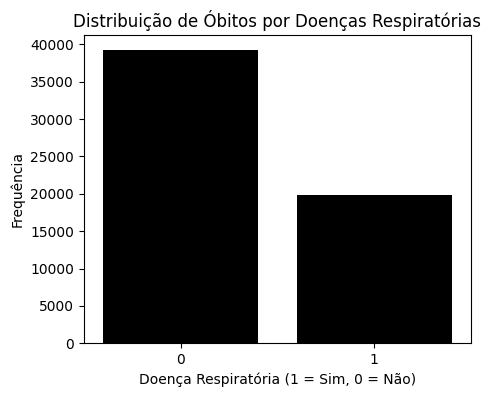

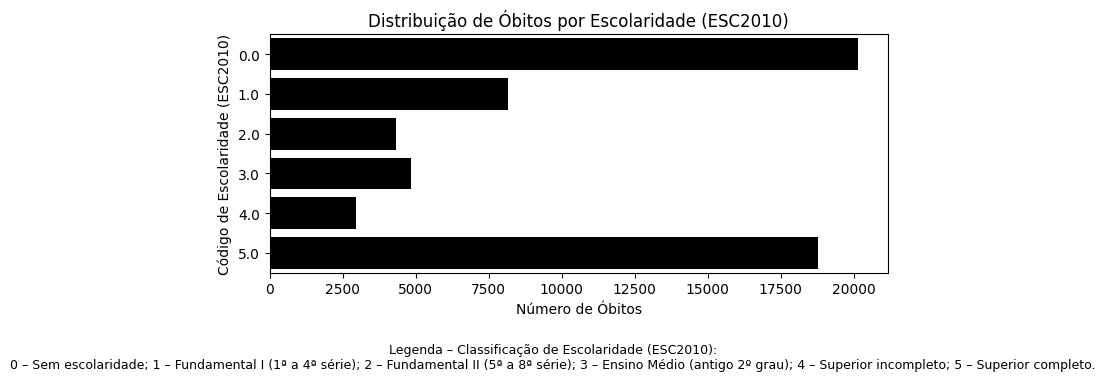

H1 - Análise Bivariada


/tmp/ipython-input-994447562.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


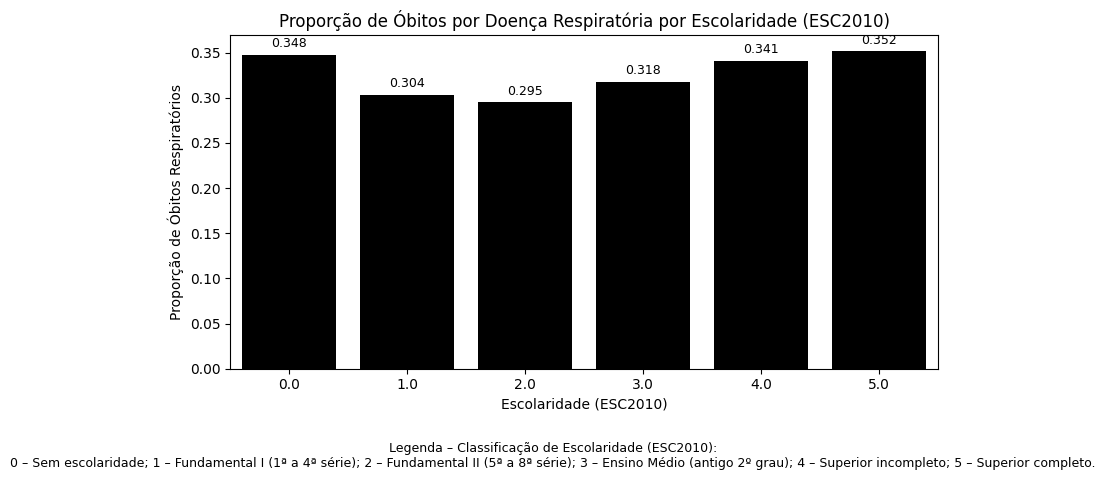

H1 - Teste de Hipótese (Unicaudal à Direita)
H₀ (Hipótese nula): As médias de óbitos por doenças respiratórias são iguais entre os grupos de baixa (0–2) e alta (3–5) escolaridade.
H₁ (Hipótese alternativa): Indivíduos com menor escolaridade (0–2) apresentam maior probabilidade de óbito por doenças respiratórias.


--- Teste T de Student (Unicaudal à Direita) ---
Estatística t: -3.6953
p-valor (unicaudal): 0.999890
Falha em rejeitar H₀: Não há evidência estatística suficiente para afirmar que indivíduos com menor escolaridade apresentam maior probabilidade de óbito.


In [69]:
parquet = pd.read_parquet("filtradoParquet.parquet")

# =============================================================================
# H1 - Escolaridade e óbitos por causas respiratórias
# =============================================================================

print("=" * 80)
print("H1: Indivíduos com menor escolaridade apresentaram maior probabilidade de óbito por causas respiratórias em 2020, nas capitais brasileiras mais populosas")
print("=" * 80)

# ------------------------------------------------------------
# Análise univariada
# ------------------------------------------------------------

print("=" * 80)
print("H1 - Análise Univariada")
print("=" * 80)

plt.figure(figsize=(5,4))
sns.countplot(x='DOENCA_RESPIRATORIA', data=parquet, color = 'Black')
plt.title('Distribuição de Óbitos por Doenças Respiratórias')
plt.xlabel('Doença Respiratória (1 = Sim, 0 = Não)')
plt.ylabel('Frequência')
plt.show()

# Distribuição da escolaridade (ESC2010)
plt.figure(figsize=(7,4))
sns.countplot(y='ESC2010', data=parquet, color='black')
plt.title('Distribuição de Óbitos por Escolaridade (ESC2010)')
plt.ylabel('Código de Escolaridade (ESC2010)')
plt.xlabel('Número de Óbitos')
plt.suptitle(
    "Legenda – Classificação de Escolaridade (ESC2010):\n"
    "0 – Sem escolaridade; 1 – Fundamental I (1ª a 4ª série); "
    "2 – Fundamental II (5ª a 8ª série); 3 – Ensino Médio (antigo 2º grau); "
    "4 – Superior incompleto; 5 – Superior completo.",
    fontsize=9, y=0.02, ha='center'
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# ------------------------------------------------------------
# Análise bivariada
# ------------------------------------------------------------

print("=" * 80)
print("H1 - Análise Bivariada")
print("=" * 80)

# Escolaridade vs Doença Respiratória
plt.figure(figsize=(8,5))

ax = sns.barplot(
    x='ESC2010',
    y='DOENCA_RESPIRATORIA',
    data=parquet,
    estimator=np.mean,
    ci=None,
    color='black'
)

plt.title('Proporção de Óbitos por Doença Respiratória por Escolaridade (ESC2010)')
plt.xlabel('Escolaridade (ESC2010)')
plt.ylabel('Proporção de Óbitos Respiratórios')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.005,
        f'{height:.3f}',
        ha='center', va='bottom',
        fontsize=9, color='black'
    )
plt.suptitle(
    "Legenda – Classificação de Escolaridade (ESC2010):\n"
    "0 – Sem escolaridade; 1 – Fundamental I (1ª a 4ª série); "
    "2 – Fundamental II (5ª a 8ª série); 3 – Ensino Médio (antigo 2º grau); "
    "4 – Superior incompleto; 5 – Superior completo.",
    fontsize=9, y=0.02, ha='center'
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# ------------------------------------------------------------
# Teste de hipótese H1 ( Teste T de Student (Unicaudal à Direita))
# ------------------------------------------------------------

print("=" * 80)
print("H1 - Teste de Hipótese (Unicaudal à Direita)")
print("=" * 80)

print("H₀ (Hipótese nula): As médias de óbitos por doenças respiratórias são iguais entre os grupos de baixa (0–2) e alta (3–5) escolaridade.")
print("H₁ (Hipótese alternativa): Indivíduos com menor escolaridade (0–2) apresentam maior probabilidade de óbito por doenças respiratórias.\n")

grupo_baixa = parquet.loc[parquet['ESC2010'].isin([0, 1, 2]), 'DOENCA_RESPIRATORIA']
grupo_alta = parquet.loc[parquet['ESC2010'].isin([3, 4, 5]), 'DOENCA_RESPIRATORIA']

# Teste t bicaudal: a hipótese teórica assume que indivíduos com menor escolaridade estão em contextos socioeconômicos mais vulneráveis
t_stat, p_bicaudal = ttest_ind(grupo_baixa, grupo_alta, equal_var=False)

if t_stat > 0:
    p_unicaudal = p_bicaudal / 2
else:
    p_unicaudal = 1 - (p_bicaudal / 2)

print("\n--- Teste T de Student (Unicaudal à Direita) ---")
print(f"Estatística t: {t_stat:.4f}")
print(f"p-valor (unicaudal): {p_unicaudal:.6f}")

if p_unicaudal < 0.05:
    print("Rejeita-se H₀: Há evidência de que indivíduos com menor escolaridade (0–2) têm maior probabilidade de óbito por doenças respiratórias.")
else:
    print("Falha em rejeitar H₀: Não há evidência estatística suficiente para afirmar que indivíduos com menor escolaridade apresentam maior probabilidade de óbito.")

### H2: Capitais localizadas nas regiões Norte e Nordeste apresentaram maior proporção de óbitos por causas respiratórias em 2020 em comparação às demais regiões


H2: Diferenças regionais na proporção de óbitos por doenças respiratórias
H2 - Análise Univariada


/tmp/ipython-input-3136471983.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


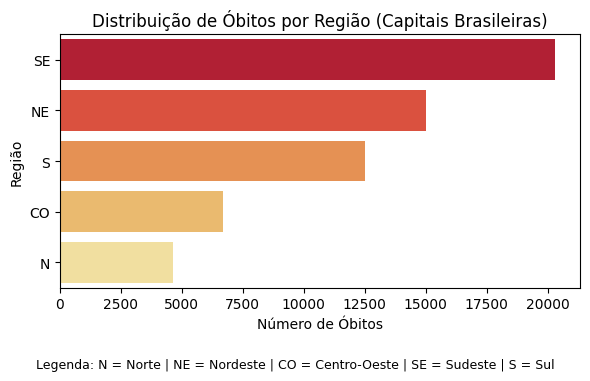

H2 - Análise Bivariada


/tmp/ipython-input-3136471983.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-3136471983.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


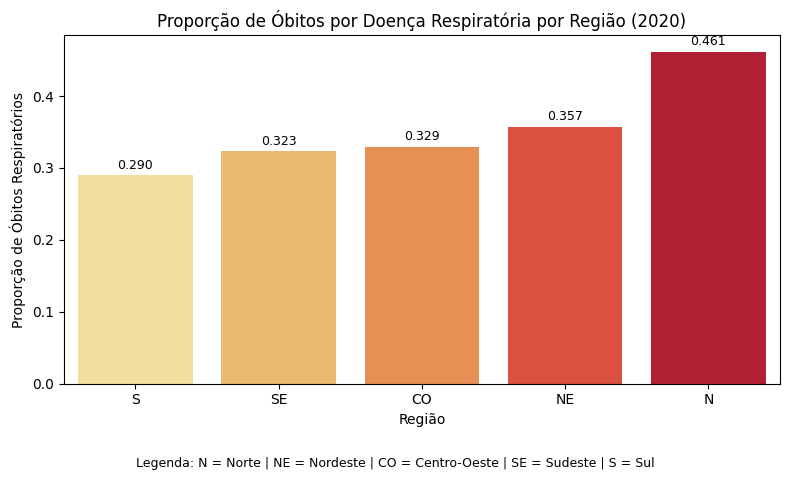

H2 - Teste de Hipótese
H₀ (Hipótese nula): Não há diferença significativa na proporção de óbitos por doenças respiratórias entre as regiões Norte/Nordeste e as demais regiões.
H₁ (Hipótese alternativa): As regiões Norte e Nordeste apresentam proporção significativamente maior de óbitos por doenças respiratórias.


--- Teste T de Student ---
Estatística t: 16.3920
p-valor: 0.000000
Rejeita-se H0: As regiões Norte e Nordeste apresentam proporção significativamente maior de óbitos por doenças respiratórias.


In [84]:
parquet = pd.read_parquet("filtradoParquet.parquet")

# =============================================================================
# H2: Capitais localizadas nas regiões Norte e Nordeste apresentaram maior proporção de óbitos por causas respiratórias em 2020 em comparação às demais regiões
# =============================================================================

print("\n" + "=" * 80)
print("H2: Diferenças regionais na proporção de óbitos por doenças respiratórias")
print("=" * 80)

# ------------------------------------------------------------
# Análise univariada
# ------------------------------------------------------------
print("=" * 80)
print("H2 - Análise Univariada")
print("=" * 80)

# Conta os óbitos por região e ordena
ordem_regioes = (
    parquet['REGIAO']
    .value_counts()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(6,4))
sns.countplot(
    y='REGIAO',
    data=parquet,
    color=None,
    palette='YlOrRd_r',
    order=ordem_regioes
)
plt.title('Distribuição de Óbitos por Região (Capitais Brasileiras)')
plt.ylabel('Região')
plt.xlabel('Número de Óbitos')
plt.suptitle(
    "Legenda: N = Norte | NE = Nordeste | CO = Centro-Oeste | SE = Sudeste | S = Sul",
    fontsize=9, y=0.02, ha='center'
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# ------------------------------------------------------------
# Análise bivariada
# ------------------------------------------------------------
print("=" * 80)
print("H2 - Análise Bivariada")
print("=" * 80)

# Média de óbitos respiratórios por região, ordenada
ordem_regioes_bivariada = (
    parquet.groupby('REGIAO')['DOENCA_RESPIRATORIA']
    .mean()
    .sort_values(ascending=True)
    .index
)

plt.figure(figsize=(8,5))
ax = sns.barplot(
    x='REGIAO',
    y='DOENCA_RESPIRATORIA',
    data=parquet,
    estimator=np.mean,
    ci=None,
    palette='YlOrRd',
    order=ordem_regioes_bivariada
)

plt.title('Proporção de Óbitos por Doença Respiratória por Região (2020)')
plt.xlabel('Região')
plt.ylabel('Proporção de Óbitos Respiratórios')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.005,
        f'{height:.3f}',
        ha='center', va='bottom',
        fontsize=9, color='black'
    )

plt.suptitle(
    "Legenda: N = Norte | NE = Nordeste | CO = Centro-Oeste | SE = Sudeste | S = Sul",
    fontsize=9, y=0.02, ha='center'
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# ------------------------------------------------------------
# Teste de hipótese H2 (Teste T de Student)
# ------------------------------------------------------------

print("=" * 80)
print("H2 - Teste de Hipótese")
print("=" * 80)

print("H₀ (Hipótese nula): Não há diferença significativa na proporção de óbitos por doenças respiratórias entre as regiões Norte/Nordeste e as demais regiões.")
print("H₁ (Hipótese alternativa): As regiões Norte e Nordeste apresentam proporção significativamente maior de óbitos por doenças respiratórias.\n")

# Norte/Nordeste vs Demais Regiões
grupo_norte_ne = parquet[parquet['REGIAO'].isin(['N', 'NE'])]['DOENCA_RESPIRATORIA']
grupo_outras = parquet[~parquet['REGIAO'].isin(['N', 'NE'])]['DOENCA_RESPIRATORIA']

t_stat, p_valor = ttest_ind(grupo_norte_ne, grupo_outras, equal_var=False)

print("\n--- Teste T de Student ---")
print(f"Estatística t: {t_stat:.4f}")
print(f"p-valor: {p_valor:.6f}")

if p_valor < 0.05:
    print("Rejeita-se H0: As regiões Norte e Nordeste apresentam proporção significativamente maior de óbitos por doenças respiratórias.")
else:
    print("Falha em rejeitar H0: Não há evidência de diferença significativa entre as regiões.")

### Insights

- H1:
Não houve evidência significativa para confirmar que indivíduos com menor escolaridade apresentaram maior probabilidade de óbito por causas respiratórias.
- H2:
Indicou diferenças relevantes entre as regiões, com Norte e Nordeste apresentando proporções mais altas de mortes em comparação ao Centro-Sul.
- Modelagens:
Serão elaboradas a partir da evolução mensal dos óbitos, projetando o décimo terceiro mês para estimar se as diferenças regionais e de escolaridade se mantêm ou se intensificam ao longo do tempo.